In [1]:
# Import basic libraries
import dask.distributed as dsk
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# Plotting libraries
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cmocean as cm
import matplotlib.pyplot as plt

# Start client
clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33793,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:34691,Total threads: 4
Dashboard: /proxy/45373/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:42493,


# Monthly averaged data

In [2]:
path_era5_monthly = '/g/data/rt52/era5/single-levels/monthly-averaged/'

In [3]:
# These are the directory names, concatonated on the path above
variables = ['2t', 'mtpr', '10u', '10v', 'msdrswrf', 'aluvp']

Open concatenated variables:

In [5]:
# data is an empty dictionary
data = {}
# loop for the list in variables 
for v in variables:
    print('Opening: '+v)
    # loop through all directories to find the data files required over multiple years
    listv = np.sort(glob.glob(path_era5_monthly+v+'/**/*.nc'))
    data[v] = xr.open_mfdataset(listv)
    print('Opened')

Opening: 2t
Opened
Opening: mtpr
Opened
Opening: 10u
Opened
Opening: 10v
Opened
Opening: msdrswrf
Opened
Opening: aluvp
Opened


In [10]:
# Rename 2t temperature to be consistent
data['2t'] = data['2t'].rename({'t2m':'2t'})

Calculate `wind` and `sns`

In [19]:
data['sns'] = xr.Dataset({'sns':(1 - data['aluvp']['aluvp'])*data['msdrswrf']['msdrswrf']})
# Calculate wind speed from zonal and meridional components
data['wind'] = xr.Dataset({'wind':np.sqrt(data['10u']['u10']**2+data['10v']['v10']**2).rename('wind')})

Extract the locations of interest from the csv file and put them in a dataarray:

In [6]:
df = pd.read_csv('/g/data/e14/jn8053/andy-pitman/islands_AUS_export.csv')
locations = df.to_xarray()
extracted_data = xr.Dataset(data_vars = {'ulm_ID':locations['ulm_ID'],'long':locations['long'],'lat':locations['lat']})

Get nearest gridpoint in ERA5 for all variables (except u10 and v10 from the list because we don't want them):

In [21]:
for v in ['2t', 'mtpr', 'wind', 'msdrswrf', 'aluvp', 'sns']:
    for var_name in data[v].data_vars:
        ext = data[v][var_name].sel(longitude = extracted_data['long'], latitude = extracted_data['lat'], method = 'nearest')
        extracted_data[v] = xr.DataArray(ext, 
                                         dims = {'time', 'index'}, 
                                         coords = {'index':extracted_data['index'], 'time':data[v]['time']}).rename(v)

2022-10-17 12:08:26,511 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-10-17 12:08:27,164 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-10-17 12:08:27,616 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-10-17 12:08:28,275 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2022-10-17 12:08:28,769 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2022-10-17 12:08:29,249 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-10-17 12:08:29,792 - distributed.utils_perf - WARNING - full garbage collections took 49% CPU time recently (threshold: 10%)
2022-10-17 12:08:30,258 - distributed.utils_perf - WARNING - full garbage collections took

In [24]:
# Replace negative values in rainfall with 0
extracted_data['mtpr'] = xr.where(extracted_data['mtpr']<0, 0, extracted_data['mtpr'])

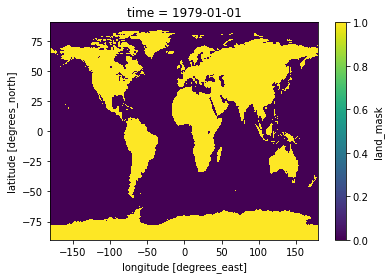

In [28]:
# Add land mask variable (1 == land, 0 == ocean). For this, we open a variable that we know is masked (in this case, wind)
# Open just one file, we don't care about time variations
mask = xr.open_dataset('/g/data/rt52/era5/single-levels/monthly-averaged/wind/1979/wind_era5_moda_sfc_19790101-19790131.nc')['wind']
mask = xr.where(np.isnan(mask), 1, 0).rename('land_mask')
mask.plot()

In [31]:
ext = mask.sel(longitude = extracted_data['long'], latitude = extracted_data['lat'], method = 'nearest')
extracted_data['land_mask'] = xr.DataArray(ext.squeeze(), 
                                           dims = {'index'}, 
                                           coords = {'index':extracted_data['index']})

In [32]:
# write out the data
# This data DOESN'T have Tmax, Tmin, or RH. Go to last section in this notebook for that.
extracted_data.to_netcdf('ERA5-monthly_averaged_NOmn2tmx2tRH.nc')

2022-10-17 12:10:48,344 - distributed.utils_perf - WARNING - full garbage collections took 49% CPU time recently (threshold: 10%)
2022-10-17 12:10:54,044 - distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
2022-10-17 12:11:03,783 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-10-17 12:11:41,763 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-10-17 12:11:46,503 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-10-17 12:11:47,842 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-10-17 12:11:49,036 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-10-17 12:13:14,610 - distributed.utils_perf - WARNING - full garbage collections took

## Make time-mean plots:

In [63]:
data = xr.open_mfdataset(['ERA5-monthly_averaged_NOmn2tmx2tRH.nc'])

In [101]:
# Make figure instance with Aus. maps
def australia_plot():
    # Projection
    albo = ccrs.AlbersEqualArea(central_latitude=0,
                                false_easting=0, 
                                false_northing=0, 
                                central_longitude=132, 
                                standard_parallels=(-18, -36))
    fig = plt.figure(figsize=(20,10))
    axs = [fig.add_subplot(231, projection=albo),
           fig.add_subplot(232, projection=albo),
           fig.add_subplot(233, projection=albo),
           fig.add_subplot(234, projection=albo),
           fig.add_subplot(235, projection=albo),
           fig.add_subplot(236, projection=albo)]
    for ax in axs:
        ax.set_extent([112, 156, -44, -7])
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                       edgecolor = 'black', facecolor = 'gainsboro'), zorder = 0)
        ax.gridlines()
    return fig, axs

In [103]:
lon, lat = data['long'], data['lat']

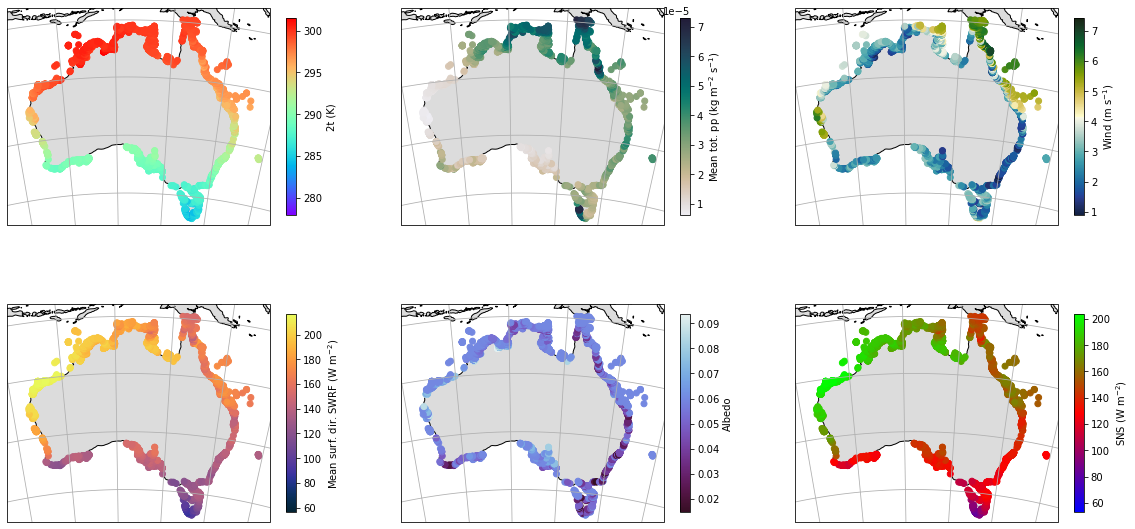

In [104]:
fig, axs = australia_plot();
p = axs[0].scatter(lon, lat, c = data['2t'].mean('time'), cmap = 'rainbow',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[0], shrink = .8).set_label('2t (K)')
p = axs[1].scatter(lon, lat, c = data['mtpr'].mean('time'), cmap = cm.cm.rain,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[1], shrink = .8).set_label('Mean tot. pp (kg m$^{-2}$ s$^{-1}$)')
p = axs[2].scatter(lon, lat, c = data['wind'].mean('time'), cmap = cm.cm.delta,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[2], shrink = .8).set_label('Wind (m s$^{-1}$)')
p = axs[3].scatter(lon, lat, c = data['msdrswrf'].mean('time'), cmap = cm.cm.thermal,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[3], shrink = .8).set_label('Mean surf. dir. SWRF (W m$^{-2}$)')
p = axs[4].scatter(lon, lat, c = data['aluvp'].mean('time'), cmap = cm.cm.dense_r,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[4], shrink = .8).set_label('Albedo')
p = axs[5].scatter(lon, lat, c = data['sns'].mean('time'), cmap = 'brg',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[5], shrink = .8).set_label('SNS (W m$^{-2}$)')

## Random time series

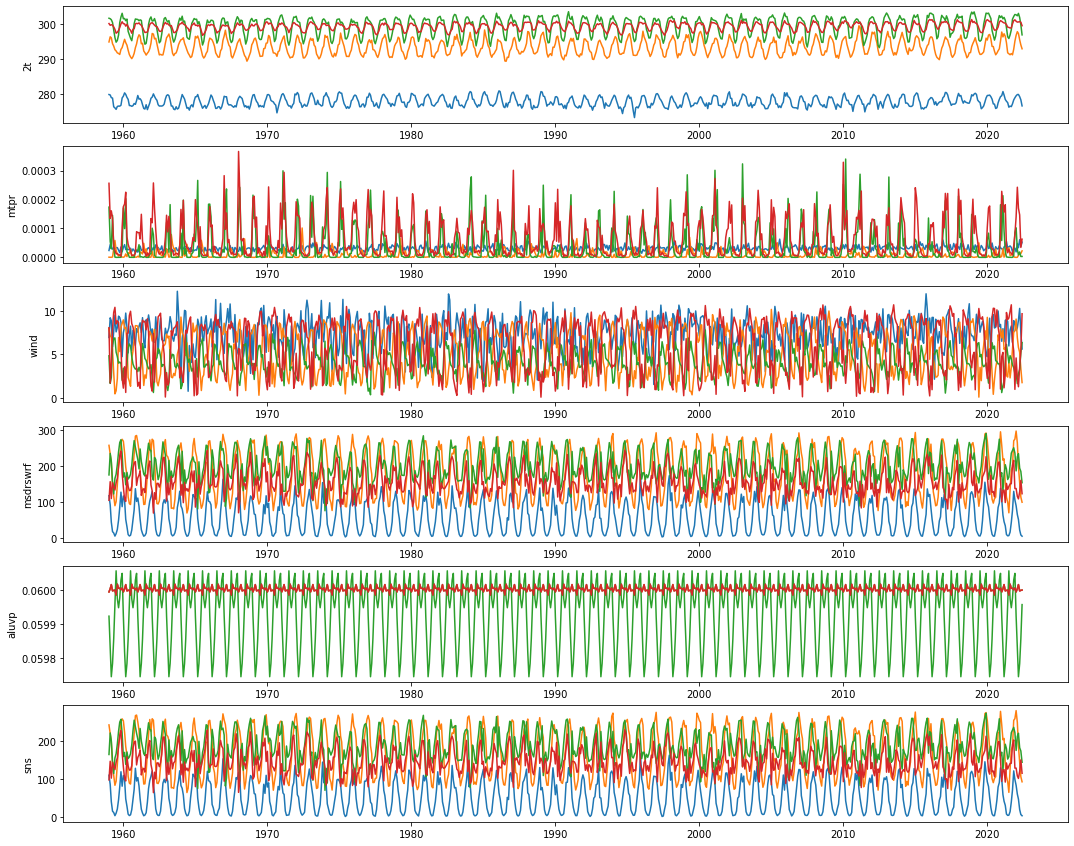

In [105]:
fig = plt.figure(figsize=(18,15))
axs = [fig.add_subplot(611),
       fig.add_subplot(612),
       fig.add_subplot(613),
       fig.add_subplot(614),
       fig.add_subplot(615),
       fig.add_subplot(616)]
n = 0
for v in ['2t', 'mtpr', 'wind', 'msdrswrf', 'aluvp', 'sns']:
    for i in [0, 1000, 3000, 4000]:
        axs[n].plot(data['time'], data[v].isel(index = i))
        axs[n].set_ylabel(v)
    n += 1

# Add `mn2t`, `mx2t` and `rh` calculated from hourly data

In [2]:
df = pd.read_csv('/g/data/e14/jn8053/andy-pitman/islands_AUS_export.csv')
locations = df.to_xarray()
extracted_data = xr.Dataset(data_vars = {'ulm_ID':locations['ulm_ID'],'long':locations['long'],'lat':locations['lat']})

In [3]:
# Avoid loading globally, and resample from hourly to daily
def preprocessing(ds):
    # Preprocess to extract Australian domain to aid computational cost
    ds = ds.sel(longitude = slice(112, 156), latitude = slice(-7, -44))
    return ds

In [4]:
path_era5_daily = '/g/data/rt52/era5/single-levels/reanalysis/'

In [5]:
variables = ['mn2t', 'mx2t', '2t', '2d']

Open concatenated datasets:

In [6]:
data = {}
for v in variables:
    print('Opening: '+v)
    listv = np.sort(glob.glob(path_era5_daily+v+'/**/*.nc'))
    data[v] = xr.open_mfdataset(listv, preprocess = preprocessing)
    print('Opened')

Opening: mn2t
Opened
Opening: mx2t
Opened
Opening: 2t
Opened
Opening: 2d
Opened


Add the `mn2t` and `mx2t` extension:

In [7]:
path_extension = '/g/data/ua8/tmp-julia/'

In [8]:
data_ext = {}
for v in ['mn2t', 'mx2t']:
    print('Opening: '+v)
    listv = np.sort(glob.glob(path_extension+v+'/**/*.nc'))
    data_ext[v] = xr.open_mfdataset(listv, preprocess = preprocessing)
    print('Opened')

Opening: mn2t
Opened
Opening: mx2t
Opened


In [9]:
# Join them 
data['mn2t'] = xr.Dataset({'mn2t':xr.concat([data['mn2t']['mn2t'],data_ext['mn2t']['mn2t']], dim = 'time').sortby('time')})
data['mx2t'] = xr.Dataset({'mx2t':xr.concat([data['mx2t']['mx2t'],data_ext['mx2t']['mx2t']], dim = 'time').sortby('time')})

`mn2t` and `mx2t` have a different time dimension from the others, its not hourly, but starts at 7hs and goes on until 23hs

Calculate relative humidity:

$$RH = 100 exp(\frac{cb(DP-T)}{(c+T)(c+DP)})$$

with b = 17.625 and c = 243.04

In [10]:
data['rh'] = xr.Dataset({'rh':
                         100*np.exp(243.04*17.625*(data['2d']['d2m'] - data['2t']['t2m']) / ((243.04+data['2t']['t2m'])*(243.04+data['2d']['d2m'])))})

In [11]:
mn2t_loc = data['mn2t']['mn2t'].sel(longitude = extracted_data['long'], latitude = extracted_data['lat'], method = 'nearest')
mx2t_loc = data['mx2t']['mx2t'].sel(longitude = extracted_data['long'], latitude = extracted_data['lat'], method = 'nearest')
rh_loc = data['rh']['rh'].sel(longitude = extracted_data['long'], latitude = extracted_data['lat'], method = 'nearest')

Intermediate saving (faster than saving everything at the end):

In [14]:
mn2t_loc.chunk({'time':'500MB'}).to_netcdf('mn2t.nc')

In [15]:
mx2t_loc.chunk({'time':'500MB'}).to_netcdf('mx2t.nc')

In [16]:
rh_loc.chunk({'time':'500MB'}).to_netcdf('rh.nc')

In [2]:
mn2t = xr.open_dataset('mn2t.nc')
mx2t = xr.open_dataset('mx2t.nc')
rh = xr.open_dataset('rh.nc')

Resample in time

In [9]:
# Calculate monthly average of mn2t and mx2t
# First go from hourly to daily (loading first improves time)
mn2t = mn2t['mn2t'].load()
mn2t_daily = mn2t.resample(time = '1D').min('time')
mx2t = mx2t['mx2t'].load()
mx2t_daily = mx2t.resample(time = '1D').min('time')

In [10]:
# Now go from daily minimum to monthly average
mn2t_monthly = mn2t_daily.resample(time = '1M').mean('time')
mx2t_monthly = mx2t_daily.resample(time = '1M').mean('time')

In [13]:
rh = rh['rh'].load()
rh_monthly = rh.resample(time = '1M').mean('time')

In [14]:
done_data = xr.open_mfdataset(['ERA5-monthly_averaged_NOmn2tmx2tRH.nc'])

In [15]:
# Change time dimension stamp to coincide with the other data
rh_monthly['time'] = done_data['time']
mn2t_monthly['time'] = done_data['time']
mx2t_monthly['time'] = done_data['time']

In [18]:
done_data['mn2t'] = xr.DataArray(mn2t_monthly, 
                                 dims = {'index', 'time'}, 
                                 coords = {'index':done_data['index'], 'time':done_data['time']}).rename('mn2t')

In [19]:
done_data['mx2t'] = xr.DataArray(mx2t_monthly, 
                                 dims = {'index', 'time'}, 
                                 coords = {'index':done_data['index'], 'time':done_data['time']}).rename('mx2t')

In [20]:
done_data['rh'] = xr.DataArray(rh_monthly, 
                               dims = {'index', 'time'}, 
                               coords = {'index':done_data['index'], 'time':done_data['time']}).rename('rh')

Add some metadata

In [21]:
done_data['mtpr'].attrs['units'] = 'kg m**-2 s**-1'
done_data['mtpr'].attrs['long_name'] = 'Mean total precipitation rate'

In [22]:
done_data['wind'].attrs['units'] = 'm s**-1'
done_data['wind'].attrs['long_name'] = 'Wind speed at 10m from u and v'

In [23]:
done_data['mn2t'].attrs['units'] = 'K'
done_data['mn2t'].attrs['long_name'] = 'Minimum 2 metre temperature'
done_data['mn2t'].attrs['description'] = 'Monthly average of daily minimum temperature, which was calculated as the minimum value from hourly data'

In [24]:
done_data['mx2t'].attrs['units'] = 'K'
done_data['mx2t'].attrs['long_name'] = 'Maximum 2 metre temperature'
done_data['mx2t'].attrs['description'] = 'Monthly average of daily maximum temperature, which was calculated as the maximum value from hourly data'

In [25]:
done_data['rh'].attrs['units'] = ''
done_data['rh'].attrs['long_name'] = 'Relative humidity'
done_data['rh'].attrs['description'] = 'Calculated using 2 metre temperature and dewpoint'

Saving takes time because it has to load into memory:

In [27]:
done_data.to_netcdf('ERA5-monthly_averaged.nc')

## Make time-mean plots:

In [28]:
data = xr.open_dataset('ERA5-monthly_averaged.nc')

In [29]:
def australia_plot():
    # Projection
    albo = ccrs.AlbersEqualArea(central_latitude=0,
                                false_easting=0, 
                                false_northing=0, 
                                central_longitude=132, 
                                standard_parallels=(-18, -36))
    fig = plt.figure(figsize=(20,8))
    axs = [fig.add_subplot(241, projection=albo),
           fig.add_subplot(242, projection=albo),
           fig.add_subplot(243, projection=albo),
           fig.add_subplot(244, projection=albo),
           fig.add_subplot(245, projection=albo),
           fig.add_subplot(246, projection=albo),
           fig.add_subplot(247, projection=albo),
           fig.add_subplot(248, projection=albo)]
    for ax in axs:
        ax.set_extent([112, 156, -44, -7])
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                       edgecolor = 'black', facecolor = 'gainsboro'), zorder = 0)
        ax.gridlines()
    return fig, axs

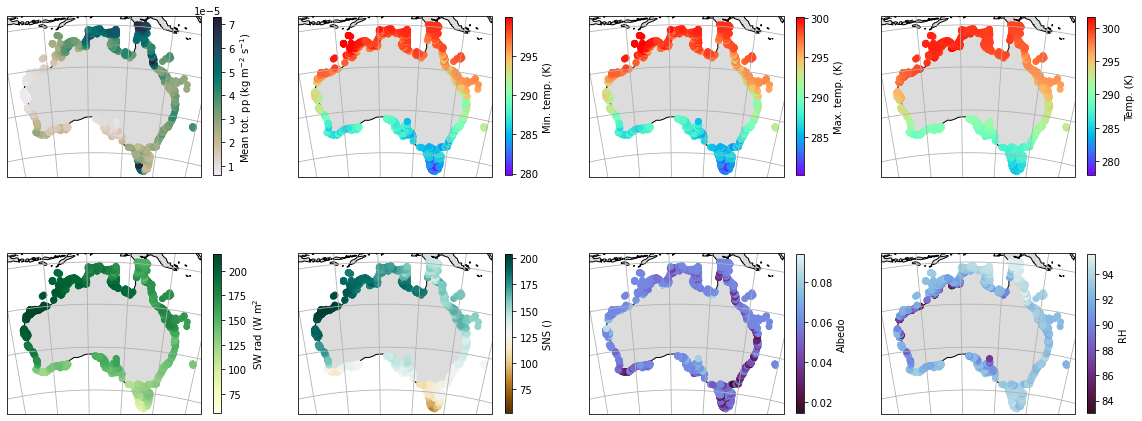

In [33]:
fig, axs = australia_plot();
p = axs[0].scatter(data['long'], data['lat'], c = data['mtpr'].mean('time'), cmap = cm.cm.rain,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[0], shrink = .8).set_label('Mean tot. pp (kg m$^{-2}$ s$^{-1}$)')
p = axs[1].scatter(data['long'], data['lat'], c = data['mn2t'].mean('time'), cmap = 'rainbow',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[1], shrink = .8).set_label('Min. temp. (K)')
p = axs[2].scatter(data['long'], data['lat'], c = data['mx2t'].mean('time'), cmap = 'rainbow',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[2], shrink = .8).set_label('Max. temp. (K)')
p = axs[3].scatter(data['long'], data['lat'], c = data['2t'].mean('time'), cmap = 'rainbow',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[3], shrink = .8).set_label('Temp. (K)')
p = axs[4].scatter(data['long'], data['lat'], c = data['msdrswrf'].mean('time'), cmap = 'YlGn',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[4], shrink = .8).set_label('SW rad (W m$^{2}$')
p = axs[5].scatter(data['long'], data['lat'], c = data['sns'].mean('time'), cmap = 'BrBG',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[5], shrink = .8).set_label('SNS ()')
p = axs[6].scatter(data['long'], data['lat'], c = data['aluvp'].mean('time'), cmap = cm.cm.dense_r,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[6], shrink = .8).set_label('Albedo')
p = axs[7].scatter(data['long'], data['lat'], c = data['rh'].mean('time'), cmap = cm.cm.dense_r,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[7], shrink = .8).set_label('RH')